# Tensorflow.keras implementation of full precision CNN for CIFAR 100 
##  https://arxiv.org/abs/1802.08530
## M. D. McDonnell, 
## Training wide residual networks for deployment using a single bit for each weight
## ICLR, 2018

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
WhichDataSet = 'CIFAR10'
#WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 254
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 160)  320         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [5]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/254
10000/10000 [==============================] - 6s 625us/sample - loss: 3.7551 - acc: 0.6297

 End of Epoch Learning Rate = 0.050005
400/400 [==============================] - 107s 269ms/step - loss: 4.4374 - acc: 0.4918 - val_loss: 3.7551 - val_acc: 0.6297

 Start of Epoch Learning Rate = 0.050005
Epoch 2/254
10000/10000 [==============================] - 6s 588us/sample - loss: 3.2203 - acc: 0.7661

 End of Epoch Learning Rate = 0.000010
400/400 [==============================] - 104s 260ms/step - loss: 3.4692 - acc: 0.6864 - val_loss: 3.2203 - val_acc: 0.7661

 Start of Epoch Learning Rate = 0.100000
Epoch 3/254
10000/10000 [==============================] - 6s 593us/sample - loss: 2.8396 - acc: 0.6520

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 104s 260ms/step - loss: 3.1206 - acc: 0.6644 - val_loss: 2.8396 - val_acc: 0.6520

 Start of Epoch Le

10000/10000 [==============================] - 6s 588us/sample - loss: 0.7053 - acc: 0.9084

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 104s 261ms/step - loss: 0.6838 - acc: 0.9268 - val_loss: 0.7053 - val_acc: 0.9084

 Start of Epoch Learning Rate = 0.022229
Epoch 53/254
10000/10000 [==============================] - 6s 581us/sample - loss: 0.6735 - acc: 0.9184

 End of Epoch Learning Rate = 0.018289
400/400 [==============================] - 104s 261ms/step - loss: 0.6617 - acc: 0.9335 - val_loss: 0.6735 - val_acc: 0.9184

 Start of Epoch Learning Rate = 0.018289
Epoch 54/254
10000/10000 [==============================] - 6s 584us/sample - loss: 0.6381 - acc: 0.9299

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 104s 261ms/step - loss: 0.6377 - acc: 0.9412 - val_loss: 0.6381 - val_acc: 0.9299

 Start of Epoch Learning Rate = 0.014653
Epoch 55/254
10000/10000 [==============================] - 6s 588us/sample -

10000/10000 [==============================] - 6s 580us/sample - loss: 0.6974 - acc: 0.9062

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 104s 260ms/step - loss: 0.6740 - acc: 0.9313 - val_loss: 0.6974 - val_acc: 0.9062

 Start of Epoch Learning Rate = 0.026438
Epoch 105/254
10000/10000 [==============================] - 6s 585us/sample - loss: 0.7055 - acc: 0.9066

 End of Epoch Learning Rate = 0.024302
400/400 [==============================] - 104s 260ms/step - loss: 0.6580 - acc: 0.9366 - val_loss: 0.7055 - val_acc: 0.9066

 Start of Epoch Learning Rate = 0.024302
Epoch 106/254
10000/10000 [==============================] - 6s 575us/sample - loss: 0.7164 - acc: 0.9030

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 104s 260ms/step - loss: 0.6463 - acc: 0.9389 - val_loss: 0.7164 - val_acc: 0.9030

 Start of Epoch Learning Rate = 0.022229
Epoch 107/254
10000/10000 [==============================] - 6s 584us/sampl

10000/10000 [==============================] - 6s 579us/sample - loss: 0.9469 - acc: 0.8509

 End of Epoch Learning Rate = 0.087049
400/400 [==============================] - 104s 260ms/step - loss: 0.9083 - acc: 0.8742 - val_loss: 0.9469 - val_acc: 0.8509

 Start of Epoch Learning Rate = 0.087049
Epoch 157/254
10000/10000 [==============================] - 6s 577us/sample - loss: 1.1309 - acc: 0.7810

 End of Epoch Learning Rate = 0.086214
400/400 [==============================] - 104s 259ms/step - loss: 0.9006 - acc: 0.8758 - val_loss: 1.1309 - val_acc: 0.7810

 Start of Epoch Learning Rate = 0.086214
Epoch 158/254
10000/10000 [==============================] - 6s 581us/sample - loss: 1.0825 - acc: 0.8103

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 104s 260ms/step - loss: 0.8947 - acc: 0.8778 - val_loss: 1.0825 - val_acc: 0.8103

 Start of Epoch Learning Rate = 0.085357
Epoch 159/254
10000/10000 [==============================] - 6s 584us/sampl

10000/10000 [==============================] - 6s 592us/sample - loss: 0.7190 - acc: 0.9037

 End of Epoch Learning Rate = 0.028629
400/400 [==============================] - 104s 261ms/step - loss: 0.6723 - acc: 0.9330 - val_loss: 0.7190 - val_acc: 0.9037

 Start of Epoch Learning Rate = 0.028629
Epoch 209/254
10000/10000 [==============================] - 6s 583us/sample - loss: 0.7514 - acc: 0.8979

 End of Epoch Learning Rate = 0.027527
400/400 [==============================] - 104s 259ms/step - loss: 0.6683 - acc: 0.9330 - val_loss: 0.7514 - val_acc: 0.8979

 Start of Epoch Learning Rate = 0.027527
Epoch 210/254
10000/10000 [==============================] - 6s 578us/sample - loss: 0.6996 - acc: 0.9067

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 104s 259ms/step - loss: 0.6584 - acc: 0.9367 - val_loss: 0.6996 - val_acc: 0.9067

 Start of Epoch Learning Rate = 0.026438
Epoch 211/254
10000/10000 [==============================] - 6s 597us/sampl

In [6]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 96.65


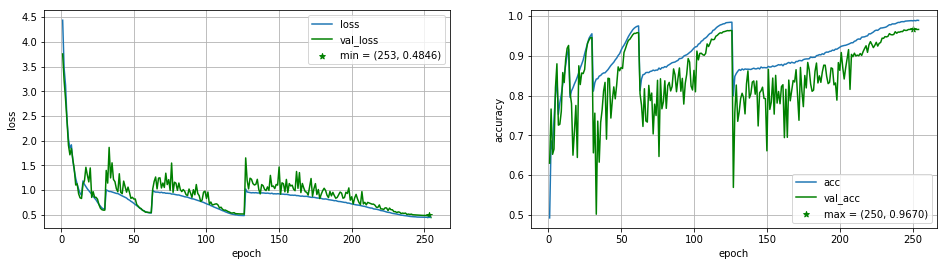

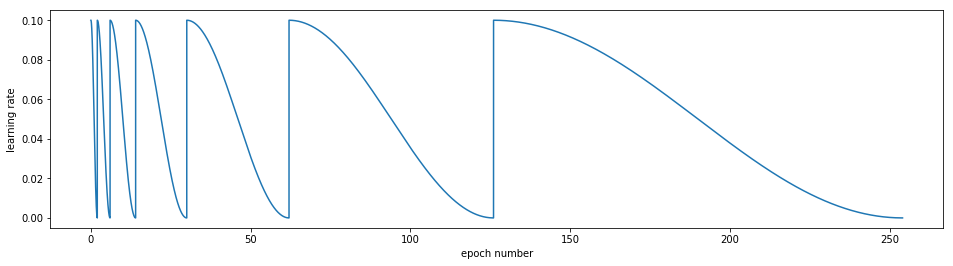

In [7]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [8]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_32bit_model_v2.h5')

In [10]:
#try again without warm restart wth 300 epochs cosine schedule
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

epochs=300

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)


 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 6s 613us/sample - loss: 3.7788 - acc: 0.5511

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 102s 256ms/step - loss: 4.4236 - acc: 0.4811 - val_loss: 3.7788 - val_acc: 0.5511

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 6s 576us/sample - loss: 3.2365 - acc: 0.4717

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 101s 252ms/step - loss: 3.1612 - acc: 0.6442 - val_loss: 3.2365 - val_acc: 0.4717

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 6s 575us/sample - loss: 2.3481 - acc: 0.6470

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 101s 253ms/step - loss: 2.4106 - acc: 0.7147 - val_loss: 2.3481 - val_acc: 0.6470

 Start of Epoch Learning Rate = 0.099975
Epoch 4/300
10000/10000 [

10000/10000 [==============================] - 6s 577us/sample - loss: 0.9638 - acc: 0.8417

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 101s 253ms/step - loss: 0.9213 - acc: 0.8650 - val_loss: 0.9638 - val_acc: 0.8417

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 6s 578us/sample - loss: 1.0641 - acc: 0.8077

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 101s 253ms/step - loss: 0.9226 - acc: 0.8643 - val_loss: 1.0641 - val_acc: 0.8077

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 6s 575us/sample - loss: 0.9993 - acc: 0.8293

 End of Epoch Learning Rate = 0.091934
400/400 [==============================] - 101s 253ms/step - loss: 0.9176 - acc: 0.8682 - val_loss: 0.9993 - val_acc: 0.8293

 Start of Epoch Learning Rate = 0.091934
Epoch 56/300
10000/10000 [==============================] - 6s 579us/sample -

10000/10000 [==============================] - 6s 576us/sample - loss: 1.0858 - acc: 0.7802

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 101s 253ms/step - loss: 0.8568 - acc: 0.8853 - val_loss: 1.0858 - val_acc: 0.7802

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 6s 574us/sample - loss: 0.9772 - acc: 0.8282

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 101s 253ms/step - loss: 0.8552 - acc: 0.8859 - val_loss: 0.9772 - val_acc: 0.8282

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 6s 584us/sample - loss: 0.9961 - acc: 0.8209

 End of Epoch Learning Rate = 0.071764
400/400 [==============================] - 101s 254ms/step - loss: 0.8548 - acc: 0.8860 - val_loss: 0.9961 - val_acc: 0.8209

 Start of Epoch Learning Rate = 0.071764
Epoch 108/300
10000/10000 [==============================] - 6s 574us/sampl

10000/10000 [==============================] - 6s 574us/sample - loss: 1.0310 - acc: 0.7940

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 101s 253ms/step - loss: 0.7553 - acc: 0.9123 - val_loss: 1.0310 - val_acc: 0.7940

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 6s 573us/sample - loss: 0.7858 - acc: 0.8894

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 101s 253ms/step - loss: 0.7510 - acc: 0.9141 - val_loss: 0.7858 - val_acc: 0.8894

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 6s 576us/sample - loss: 0.9848 - acc: 0.8252

 End of Epoch Learning Rate = 0.045300
400/400 [==============================] - 101s 254ms/step - loss: 0.7510 - acc: 0.9127 - val_loss: 0.9848 - val_acc: 0.8252

 Start of Epoch Learning Rate = 0.045300
Epoch 160/300
10000/10000 [==============================] - 6s 578us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 6s 576us/sample - loss: 0.7880 - acc: 0.8803

 End of Epoch Learning Rate = 0.029193
400/400 [==============================] - 101s 254ms/step - loss: 0.6626 - acc: 0.9362 - val_loss: 0.7880 - val_acc: 0.8803

 Start of Epoch Learning Rate = 0.029193
Epoch 192/300
10000/10000 [==============================] - 6s 576us/sample - loss: 0.7920 - acc: 0.8728

 End of Epoch Learning Rate = 0.028718
400/400 [==============================] - 101s 253ms/step - loss: 0.6580 - acc: 0.9382 - val_loss: 0.7920 - val_acc: 0.8728

 Start of Epoch Learning Rate = 0.028718
Epoch 193/300
10000/10000 [==============================] - 6s 579us/sample - loss: 0.6754 - acc: 0.9222

 End of Epoch Learning Rate = 0.028246
400/400 [==============================] - 101s 254ms/step - loss: 0.6575 - acc: 0.9372 - val_loss: 0.6754 - val_acc: 0.9222

 Start of Epoch Learning Rate = 0.028246
Epoch 194/300
10000/10000 [==============================] - 6s 576us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 6s 574us/sample - loss: 0.6580 - acc: 0.9158

 End of Epoch Learning Rate = 0.021904
400/400 [==============================] - 101s 253ms/step - loss: 0.6181 - acc: 0.9456 - val_loss: 0.6580 - val_acc: 0.9158

 Start of Epoch Learning Rate = 0.021904
Epoch 208/300
10000/10000 [==============================] - 6s 572us/sample - loss: 0.6875 - acc: 0.9114

 End of Epoch Learning Rate = 0.021472
400/400 [==============================] - 101s 253ms/step - loss: 0.6157 - acc: 0.9463 - val_loss: 0.6875 - val_acc: 0.9114

 Start of Epoch Learning Rate = 0.021472
Epoch 209/300
10000/10000 [==============================] - 6s 577us/sample - loss: 0.7794 - acc: 0.8856

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 101s 253ms/step - loss: 0.6131 - acc: 0.9470 - val_loss: 0.7794 - val_acc: 0.8856

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 6s 577us/sampl

10000/10000 [==============================] - 6s 576us/sample - loss: 0.4983 - acc: 0.9563

 End of Epoch Learning Rate = 0.004548
400/400 [==============================] - 101s 254ms/step - loss: 0.4563 - acc: 0.9816 - val_loss: 0.4983 - val_acc: 0.9563

 Start of Epoch Learning Rate = 0.004548
Epoch 260/300
10000/10000 [==============================] - 6s 576us/sample - loss: 0.5075 - acc: 0.9530

 End of Epoch Learning Rate = 0.004332
400/400 [==============================] - 101s 253ms/step - loss: 0.4525 - acc: 0.9827 - val_loss: 0.5075 - val_acc: 0.9530

 Start of Epoch Learning Rate = 0.004332
Epoch 261/300
10000/10000 [==============================] - 6s 575us/sample - loss: 0.4996 - acc: 0.9573

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 101s 253ms/step - loss: 0.4491 - acc: 0.9836 - val_loss: 0.4996 - val_acc: 0.9573

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 6s 574us/sampl

In [11]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 96.62


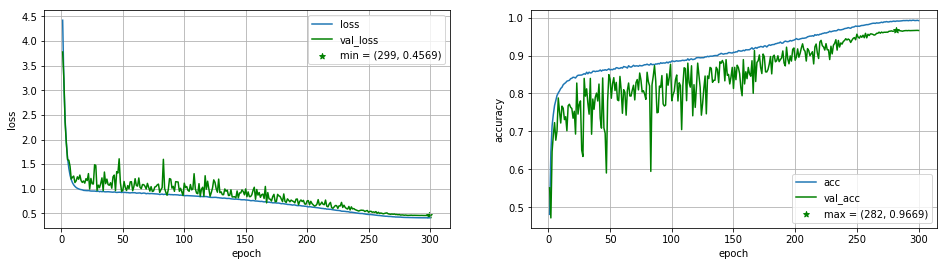

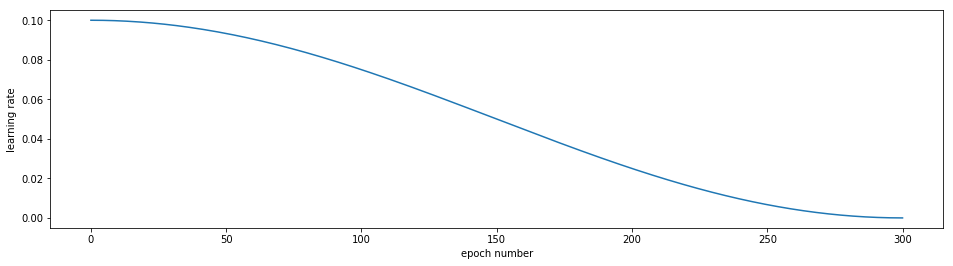

In [12]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()